<a href="https://colab.research.google.com/github/drFahlan/tumor-cell-detection-using-small-and-large-FoV/blob/main/notebooks/baseline_model_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [1]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: drfahlan (drfahlan_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# tissue segmentation

##train

In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import psutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import wandb
from PIL import Image
import cv2


In [9]:
# ---- Hyperparameters ----
config = {
    "batch_size": 4,
    "epochs": 150,
    "dropout":0.3613,
    "learning_rate": 0.0001649,
    "image_size": (1024, 1024),
    "patch_size": (512, 512),  # New parameter for patch-based training
    "dataset_path": "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1",
    "random_seed": SEED
}

In [10]:
wandb.init(project="ocelot_tissue_segmentation", name="vanillaUnet_13", reinit=True)
wandb.config.update(config)

wandb: Currently logged in as: drfahlan (drfahlan_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


KeyboardInterrupt: 

In [4]:
# ---- Set Random Seed ----
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [5]:
# ---- Paths ----
dataset_path = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1"

In [6]:
# ---- Updated Augmentation ----
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    #A.RandomCrop(height=224, width=224, p=1.0),  # Crop to 224x224
    #A.Resize(256, 256),  # Resize both image and mask to 256x256
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

val_transform = A.Compose([
    #A.Resize(256, 256),  # Ensures validation images and masks are 256x256
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])


In [7]:
class TissueDataset(Dataset):
    def __init__(self, split, transform=None, patch_size=None):
        self.image_dir = os.path.join(config["dataset_path"], f"images/{split}/tissue")
        self.annotation_dir = os.path.join(config["dataset_path"], f"annotations/{split}/tissue")
        self.filenames = [f for f in os.listdir(self.image_dir) if f.endswith(".jpg")]
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        ann_path = os.path.join(self.annotation_dir, img_name.replace(".jpg", ".png"))

        image = np.array(Image.open(img_path).convert("RGB"))
        annotation = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)

        # Fix labels: Change `2` → `1` and ignore `255`
        annotation[annotation == 1] = 0
        annotation[annotation == 2] = 1

        if self.patch_size is not None:
            h, w = image.shape[:2]
            ph, pw = self.patch_size
            if h < ph or w < pw:
                raise ValueError("Image is smaller than the patch size")
            top = np.random.randint(0, h - ph + 1)
            left = np.random.randint(0, w - pw + 1)
            image = image[top:top+ph, left:left+pw]
            annotation = annotation[top:top+ph, left:left+pw]

        if self.transform:
            transformed = self.transform(image=image, mask=annotation)
            image, annotation = transformed["image"], transformed["mask"]

        return image, annotation.long()


In [11]:
# ---- Load Data ----
train_dataset = TissueDataset("train", transform=train_transform, patch_size=config["patch_size"])
val_dataset = TissueDataset("val", transform=val_transform, patch_size=config["patch_size"])

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a double convolution block: two 3x3 conv layers with ReLU activations.
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define the downsampling (encoder) block: max pooling followed by double convolution.
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)

# Define the upsampling (decoder) block: upsampling, concatenation with corresponding encoder feature map, and double convolution.
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        # If using bilinear interpolation for upsampling
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # Otherwise, use transposed convolution
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is the feature map from the previous decoder layer
        # x2 is the corresponding feature map from the encoder (skip connection)
        x1 = self.up(x1)
        # Adjust shape if necessary (due to cropping during encoder operations)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Define the output convolution that maps to the desired number of classes.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Define the full U-Net model.
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, dropout=0.1):
        """
        Args:
            n_channels: Number of input channels (e.g., 1 for grayscale, 3 for RGB)
            n_classes: Number of segmentation classes
            bilinear: Whether to use bilinear interpolation or transposed convolutions for upsampling
        """
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout = nn.Dropout(dropout)

        # Encoder: contracting path
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        # Factor to adjust the number of channels when using bilinear upsampling
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Decoder: expansive path
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        # Final output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Contracting path
        x1 = self.inc(x)       # [B, 64, H, W]
        x2 = self.down1(x1)    # [B, 128, H/2, W/2]
        x3 = self.down2(x2)    # [B, 256, H/4, W/4]
        x4 = self.down3(x3)    # [B, 512, H/8, W/8]
        x5 = self.down4(x4)    # [B, 1024/factor, H/16, W/16]

        # Expansive path with skip connections
        x = self.up1(x5, x4)   # [B, 512/factor, H/8, W/8]
        x = self.up2(x, x3)    # [B, 256/factor, H/4, W/4]
        x = self.up3(x, x2)    # [B, 128/factor, H/2, W/2]
        x = self.up4(x, x1)    # [B, 64, H, W]

        logits = self.outc(x)
        return logits


In [14]:
# ---- Training Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=2, bilinear=True, dropout=config["dropout"]).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore label 255
optimizer = optim.RMSprop(model.parameters(), lr=config["learning_rate"])


In [ ]:
wandb.watch(model, log="all")

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# ---- Training Loop with Validation, Metrics, and Best Model Saving ----
def train_model():
    best_val_loss = float("inf")
    for epoch in range(config["epochs"]):
        # ----- Training Phase -----
        model.train()
        start_time = time.time()
        total_loss, correct, total = 0, 0, 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

        train_acc = correct / total
        avg_train_loss = total_loss / len(train_loader)
        train_time = time.time() - start_time
        memory_usage = psutil.virtual_memory().percent

        # ----- Validation Phase -----
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                # Flatten predictions and labels for metric computation
                all_preds.append(preds.cpu().numpy().flatten())
                all_labels.append(masks.cpu().numpy().flatten())

        avg_val_loss = val_loss / len(val_loader)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # Compute per-class F1, macro F1, weighted F1, recall, and precision
        per_class_f1 = f1_score(all_labels, all_preds, average=None)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average=None)
        precision = precision_score(all_labels, all_preds, average=None)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "val_loss": avg_val_loss,
            "per_class_f1": per_class_f1.tolist(),
            "macro_f1": macro_f1,
            "weighted_f1": weighted_f1,
            "recall": recall.tolist(),
            "precision": precision.tolist(),
            "train_time": train_time,
            "memory_usage": memory_usage
        })

        print(f"Epoch [{epoch+1}/{config['epochs']}]: "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Time: {train_time:.2f}s, Memory: {memory_usage}%")

        # ----- Save the Best Model -----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")
            artifact = wandb.Artifact("best_model", type="model")
            artifact.add_file("best_model.pth")
            wandb.log_artifact(artifact)

train_model()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/150]: Train Loss: 1.1318, Train Acc: 0.6298, Val Loss: 0.6996, Time: 74.13s, Memory: 22.8%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/150]: Train Loss: 0.5626, Train Acc: 0.6759, Val Loss: 0.6536, Time: 71.45s, Memory: 27.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/150]: Train Loss: 0.5618, Train Acc: 0.6694, Val Loss: 0.6287, Time: 71.45s, Memory: 27.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/150]: Train Loss: 0.5647, Train Acc: 0.6646, Val Loss: 0.7113, Time: 72.04s, Memory: 29.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/150]: Train Loss: 0.5707, Train Acc: 0.6696, Val Loss: 0.6163, Time: 71.51s, Memory: 27.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/150]: Train Loss: 0.5433, Train Acc: 0.6780, Val Loss: 0.7301, Time: 71.67s, Memory: 27.6%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/150]: Train Loss: 0.5481, Train Acc: 0.6791, Val Loss: 0.5986, Time: 71.51s, Memory: 27.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/150]: Train Loss: 0.5427, Train Acc: 0.6807, Val Loss: 0.6340, Time: 69.71s, Memory: 27.6%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/150]: Train Loss: 0.5478, Train Acc: 0.6878, Val Loss: 0.6048, Time: 68.84s, Memory: 27.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/150]: Train Loss: 0.5526, Train Acc: 0.6835, Val Loss: 0.6096, Time: 71.58s, Memory: 28.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/150]: Train Loss: 0.5267, Train Acc: 0.6916, Val Loss: 0.5768, Time: 71.26s, Memory: 29.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/150]: Train Loss: 0.5457, Train Acc: 0.6872, Val Loss: 0.5586, Time: 71.73s, Memory: 27.9%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/150]: Train Loss: 0.5323, Train Acc: 0.6890, Val Loss: 0.5425, Time: 71.12s, Memory: 28.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/150]: Train Loss: 0.5322, Train Acc: 0.6888, Val Loss: 0.5463, Time: 71.28s, Memory: 30.8%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/150]: Train Loss: 0.5438, Train Acc: 0.6955, Val Loss: 0.6085, Time: 71.38s, Memory: 31.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/150]: Train Loss: 0.5053, Train Acc: 0.7033, Val Loss: 0.6011, Time: 70.75s, Memory: 31.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/150]: Train Loss: 0.5433, Train Acc: 0.7054, Val Loss: 0.5261, Time: 71.04s, Memory: 28.6%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/150]: Train Loss: 0.5124, Train Acc: 0.7024, Val Loss: 0.5804, Time: 71.75s, Memory: 31.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/150]: Train Loss: 0.5216, Train Acc: 0.7047, Val Loss: 0.5540, Time: 70.91s, Memory: 31.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/150]: Train Loss: 0.4961, Train Acc: 0.7201, Val Loss: 0.5879, Time: 72.45s, Memory: 31.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [21/150]: Train Loss: 0.5467, Train Acc: 0.7132, Val Loss: 0.5626, Time: 70.97s, Memory: 31.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [22/150]: Train Loss: 0.5019, Train Acc: 0.7153, Val Loss: 0.5420, Time: 71.10s, Memory: 31.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [23/150]: Train Loss: 0.5059, Train Acc: 0.7215, Val Loss: 0.4988, Time: 71.33s, Memory: 31.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [24/150]: Train Loss: 0.5077, Train Acc: 0.7202, Val Loss: 0.5705, Time: 71.75s, Memory: 31.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [25/150]: Train Loss: 0.5043, Train Acc: 0.7255, Val Loss: 0.5072, Time: 71.36s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [26/150]: Train Loss: 0.4838, Train Acc: 0.7371, Val Loss: 0.5899, Time: 70.95s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [27/150]: Train Loss: 0.4607, Train Acc: 0.7426, Val Loss: 0.5431, Time: 71.33s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [28/150]: Train Loss: 0.4899, Train Acc: 0.7401, Val Loss: 0.5347, Time: 71.17s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [29/150]: Train Loss: 0.4836, Train Acc: 0.7294, Val Loss: 0.5412, Time: 70.85s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [30/150]: Train Loss: 0.4749, Train Acc: 0.7508, Val Loss: 0.5108, Time: 71.54s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [31/150]: Train Loss: 0.4719, Train Acc: 0.7404, Val Loss: 0.6210, Time: 71.64s, Memory: 25.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [32/150]: Train Loss: 0.4371, Train Acc: 0.7676, Val Loss: 0.6384, Time: 70.93s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [33/150]: Train Loss: 0.4293, Train Acc: 0.7756, Val Loss: 0.5510, Time: 71.46s, Memory: 22.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [34/150]: Train Loss: 0.4429, Train Acc: 0.7657, Val Loss: 0.5354, Time: 70.91s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [35/150]: Train Loss: 0.4349, Train Acc: 0.7708, Val Loss: 0.5525, Time: 71.04s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [36/150]: Train Loss: 0.4694, Train Acc: 0.7619, Val Loss: 0.5498, Time: 71.09s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [37/150]: Train Loss: 0.4593, Train Acc: 0.7780, Val Loss: 0.4566, Time: 71.02s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [38/150]: Train Loss: 0.4247, Train Acc: 0.7833, Val Loss: 0.5935, Time: 70.98s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [39/150]: Train Loss: 0.4064, Train Acc: 0.7844, Val Loss: 0.6687, Time: 71.15s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [40/150]: Train Loss: 0.4104, Train Acc: 0.7851, Val Loss: 0.5337, Time: 70.99s, Memory: 25.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [41/150]: Train Loss: 0.4200, Train Acc: 0.7827, Val Loss: 0.7297, Time: 71.20s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [42/150]: Train Loss: 0.4309, Train Acc: 0.7821, Val Loss: 0.4837, Time: 71.01s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [43/150]: Train Loss: 0.4009, Train Acc: 0.7920, Val Loss: 0.6498, Time: 71.08s, Memory: 26.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [44/150]: Train Loss: 0.3803, Train Acc: 0.7997, Val Loss: 0.5703, Time: 71.03s, Memory: 26.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [45/150]: Train Loss: 0.3633, Train Acc: 0.8109, Val Loss: 0.6202, Time: 71.27s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [46/150]: Train Loss: 0.3849, Train Acc: 0.8010, Val Loss: 0.4612, Time: 71.12s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [47/150]: Train Loss: 0.3732, Train Acc: 0.8143, Val Loss: 0.4869, Time: 71.44s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [48/150]: Train Loss: 0.3802, Train Acc: 0.8041, Val Loss: 0.4126, Time: 71.07s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [49/150]: Train Loss: 0.3908, Train Acc: 0.7972, Val Loss: 0.4874, Time: 71.30s, Memory: 25.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [50/150]: Train Loss: 0.3611, Train Acc: 0.8170, Val Loss: 0.5384, Time: 71.18s, Memory: 21.6%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [51/150]: Train Loss: 0.3663, Train Acc: 0.8093, Val Loss: 0.8410, Time: 69.67s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [52/150]: Train Loss: 0.3504, Train Acc: 0.8190, Val Loss: 0.6055, Time: 68.81s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [53/150]: Train Loss: 0.3657, Train Acc: 0.8062, Val Loss: 0.4751, Time: 68.76s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [54/150]: Train Loss: 0.3602, Train Acc: 0.8104, Val Loss: 0.5734, Time: 70.63s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [55/150]: Train Loss: 0.3528, Train Acc: 0.8157, Val Loss: 0.5369, Time: 71.04s, Memory: 25.0%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [56/150]: Train Loss: 0.3498, Train Acc: 0.8177, Val Loss: 0.5074, Time: 70.80s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [57/150]: Train Loss: 0.3453, Train Acc: 0.8238, Val Loss: 0.4665, Time: 71.27s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [58/150]: Train Loss: 0.3269, Train Acc: 0.8256, Val Loss: 0.4389, Time: 71.30s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [59/150]: Train Loss: 0.3611, Train Acc: 0.8221, Val Loss: 0.5011, Time: 71.64s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [60/150]: Train Loss: 0.3089, Train Acc: 0.8310, Val Loss: 0.5905, Time: 71.28s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [61/150]: Train Loss: 0.3502, Train Acc: 0.8297, Val Loss: 0.4898, Time: 70.78s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [62/150]: Train Loss: 0.3187, Train Acc: 0.8393, Val Loss: 0.3825, Time: 70.81s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [63/150]: Train Loss: 0.3213, Train Acc: 0.8314, Val Loss: 0.4122, Time: 70.95s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [64/150]: Train Loss: 0.3057, Train Acc: 0.8335, Val Loss: 0.4563, Time: 70.74s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [65/150]: Train Loss: 0.3102, Train Acc: 0.8374, Val Loss: 0.4873, Time: 70.70s, Memory: 22.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [66/150]: Train Loss: 0.3162, Train Acc: 0.8393, Val Loss: 0.4313, Time: 70.75s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [67/150]: Train Loss: 0.3042, Train Acc: 0.8397, Val Loss: 0.4177, Time: 71.38s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [68/150]: Train Loss: 0.2960, Train Acc: 0.8470, Val Loss: 0.6734, Time: 70.64s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [69/150]: Train Loss: 0.3087, Train Acc: 0.8376, Val Loss: 0.5280, Time: 70.76s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [70/150]: Train Loss: 0.2924, Train Acc: 0.8450, Val Loss: 0.5348, Time: 70.76s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [71/150]: Train Loss: 0.2926, Train Acc: 0.8459, Val Loss: 0.5539, Time: 70.67s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [72/150]: Train Loss: 0.3026, Train Acc: 0.8430, Val Loss: 0.4386, Time: 70.82s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [73/150]: Train Loss: 0.2728, Train Acc: 0.8525, Val Loss: 0.5102, Time: 70.70s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [74/150]: Train Loss: 0.2859, Train Acc: 0.8440, Val Loss: 0.4553, Time: 70.53s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [75/150]: Train Loss: 0.2938, Train Acc: 0.8425, Val Loss: 0.5571, Time: 70.92s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [76/150]: Train Loss: 0.2891, Train Acc: 0.8480, Val Loss: 0.9105, Time: 70.70s, Memory: 26.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [77/150]: Train Loss: 0.2813, Train Acc: 0.8493, Val Loss: 0.5070, Time: 70.76s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [78/150]: Train Loss: 0.2646, Train Acc: 0.8563, Val Loss: 0.4420, Time: 70.55s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [79/150]: Train Loss: 0.2600, Train Acc: 0.8611, Val Loss: 0.4390, Time: 70.92s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [80/150]: Train Loss: 0.2942, Train Acc: 0.8494, Val Loss: 0.4198, Time: 70.59s, Memory: 21.6%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [81/150]: Train Loss: 0.2662, Train Acc: 0.8550, Val Loss: 0.5024, Time: 70.81s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [82/150]: Train Loss: 0.2778, Train Acc: 0.8481, Val Loss: 0.5486, Time: 70.99s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [83/150]: Train Loss: 0.2699, Train Acc: 0.8521, Val Loss: 0.3866, Time: 70.83s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [84/150]: Train Loss: 0.2752, Train Acc: 0.8536, Val Loss: 0.4893, Time: 70.72s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [85/150]: Train Loss: 0.2657, Train Acc: 0.8569, Val Loss: 0.4956, Time: 70.65s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [86/150]: Train Loss: 0.2495, Train Acc: 0.8667, Val Loss: 0.7554, Time: 70.81s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [87/150]: Train Loss: 0.2693, Train Acc: 0.8547, Val Loss: 0.4923, Time: 70.71s, Memory: 26.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [88/150]: Train Loss: 0.2769, Train Acc: 0.8568, Val Loss: 0.5044, Time: 70.71s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [89/150]: Train Loss: 0.2591, Train Acc: 0.8657, Val Loss: 0.4814, Time: 70.73s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [90/150]: Train Loss: 0.2677, Train Acc: 0.8559, Val Loss: 0.6449, Time: 70.82s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [91/150]: Train Loss: 0.2427, Train Acc: 0.8653, Val Loss: 0.4642, Time: 70.90s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [92/150]: Train Loss: 0.2558, Train Acc: 0.8643, Val Loss: 0.6569, Time: 70.72s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [93/150]: Train Loss: 0.2559, Train Acc: 0.8606, Val Loss: 0.6394, Time: 70.90s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [94/150]: Train Loss: 0.2270, Train Acc: 0.8711, Val Loss: 0.5750, Time: 70.65s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [95/150]: Train Loss: 0.2384, Train Acc: 0.8665, Val Loss: 0.4828, Time: 70.67s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [96/150]: Train Loss: 0.2374, Train Acc: 0.8660, Val Loss: 0.4948, Time: 70.87s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [97/150]: Train Loss: 0.2353, Train Acc: 0.8695, Val Loss: 0.4776, Time: 71.21s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [98/150]: Train Loss: 0.2249, Train Acc: 0.8717, Val Loss: 0.5832, Time: 71.06s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [99/150]: Train Loss: 0.2416, Train Acc: 0.8653, Val Loss: 0.8101, Time: 70.89s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [100/150]: Train Loss: 0.2484, Train Acc: 0.8640, Val Loss: 0.5394, Time: 70.98s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [101/150]: Train Loss: 0.2185, Train Acc: 0.8735, Val Loss: 0.5306, Time: 70.95s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [102/150]: Train Loss: 0.2364, Train Acc: 0.8675, Val Loss: 0.5217, Time: 70.69s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [103/150]: Train Loss: 0.2203, Train Acc: 0.8717, Val Loss: 1.0645, Time: 70.70s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [104/150]: Train Loss: 0.2188, Train Acc: 0.8766, Val Loss: 0.5014, Time: 71.04s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [105/150]: Train Loss: 0.2476, Train Acc: 0.8696, Val Loss: 0.5187, Time: 70.99s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [106/150]: Train Loss: 0.2458, Train Acc: 0.8708, Val Loss: 0.4496, Time: 70.85s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [107/150]: Train Loss: 0.2321, Train Acc: 0.8687, Val Loss: 0.5516, Time: 70.65s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [108/150]: Train Loss: 0.2246, Train Acc: 0.8743, Val Loss: 0.4795, Time: 70.76s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [109/150]: Train Loss: 0.2293, Train Acc: 0.8724, Val Loss: 0.6082, Time: 71.05s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [110/150]: Train Loss: 0.2137, Train Acc: 0.8770, Val Loss: 0.7939, Time: 70.83s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [111/150]: Train Loss: 0.2211, Train Acc: 0.8751, Val Loss: 0.7374, Time: 72.11s, Memory: 25.1%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [112/150]: Train Loss: 0.2243, Train Acc: 0.8743, Val Loss: 0.4457, Time: 71.58s, Memory: 25.6%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [113/150]: Train Loss: 0.2188, Train Acc: 0.8741, Val Loss: 0.5460, Time: 71.28s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [114/150]: Train Loss: 0.2165, Train Acc: 0.8810, Val Loss: 0.5120, Time: 71.21s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [115/150]: Train Loss: 0.2185, Train Acc: 0.8796, Val Loss: 0.5292, Time: 71.33s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [116/150]: Train Loss: 0.2269, Train Acc: 0.8721, Val Loss: 0.5207, Time: 70.89s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [117/150]: Train Loss: 0.2050, Train Acc: 0.8854, Val Loss: 0.4309, Time: 71.16s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [118/150]: Train Loss: 0.1939, Train Acc: 0.8837, Val Loss: 0.4687, Time: 70.97s, Memory: 25.2%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [119/150]: Train Loss: 0.2171, Train Acc: 0.8758, Val Loss: 0.5086, Time: 71.10s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [120/150]: Train Loss: 0.2267, Train Acc: 0.8767, Val Loss: 0.6436, Time: 71.09s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [121/150]: Train Loss: 0.2067, Train Acc: 0.8807, Val Loss: 0.4996, Time: 71.12s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [122/150]: Train Loss: 0.2052, Train Acc: 0.8821, Val Loss: 0.5831, Time: 71.17s, Memory: 25.5%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [123/150]: Train Loss: 0.2223, Train Acc: 0.8767, Val Loss: 0.7413, Time: 71.16s, Memory: 25.4%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [124/150]: Train Loss: 0.1856, Train Acc: 0.8893, Val Loss: 0.4228, Time: 71.26s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [125/150]: Train Loss: 0.2046, Train Acc: 0.8832, Val Loss: 1.0542, Time: 70.93s, Memory: 26.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [126/150]: Train Loss: 0.1992, Train Acc: 0.8850, Val Loss: 0.6814, Time: 70.84s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [127/150]: Train Loss: 0.1921, Train Acc: 0.8832, Val Loss: 0.5453, Time: 71.14s, Memory: 25.3%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [128/150]: Train Loss: 0.1982, Train Acc: 0.8853, Val Loss: 0.4837, Time: 71.02s, Memory: 25.5%


debugging

In [ ]:
for images, masks in train_loader:
    print("Unique mask values:", torch.unique(masks))


Unique mask values: tensor([0, 1, 2])
Unique mask values: tensor([0, 1, 2])
Unique mask values: tensor([0, 1, 2])
Unique mask values: tensor([0, 1, 2])


KeyboardInterrupt: 

##validation

In [15]:
import os
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

# Initialize a new run for inference (if needed)
run = wandb.init(
    project="ocelot_tissue_segmentation",
    job_type="validation",
    name="vanillaUnet_13"
)
# Download and load the best model artifact
artifact = run.use_artifact('drfahlan_/ocelot_tissue_segmentation/best_model:v12', type='model')
artifact_dir = artifact.download()

# Instantiate your model (make sure to pass the dropout from your config)
model = UNet(n_channels=3, n_classes=2, bilinear=True, dropout=config["dropout"]).to(device)
# Load the state dict from the downloaded file (adjust the filename if needed)
model.load_state_dict(torch.load(os.path.join(artifact_dir, "best_model.pth")))
model.eval()

# ----- Validation Phase -----
val_loss = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        # Flatten predictions and labels for metric computation
        all_preds.append(preds.cpu().numpy().flatten())
        all_labels.append(masks.cpu().numpy().flatten())

avg_val_loss = val_loss / len(val_loader)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute metrics
per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)

print("Validation Loss: {:.4f}".format(avg_val_loss))
print("Per-class F1: ", per_class_f1)
print("Macro F1: ", macro_f1)
print("Weighted F1: ", weighted_f1)
print("Recall: ", recall)
print("Precision: ", precision)

# Optionally, log these metrics to wandb
wandb.log({
    "validation_loss": avg_val_loss,
    "per_class_f1": per_class_f1.tolist(),
    "macro_f1": macro_f1,
    "weighted_f1": weighted_f1,
    "recall": recall.tolist(),
    "precision": precision.tolist()
})


wandb: Downloading large artifact best_model:v12, 51.08MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3
<ipython-input-15-35d165f8a9a0>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to

Validation Loss: 0.3751
Per-class F1:  [0.8299681  0.80306112 0.        ]
Macro F1:  0.5443430733971888
Weighted F1:  0.779975736414316
Recall:  [0.87657486 0.79148459 0.        ]
Precision:  [0.78806722 0.81498132 0.        ]


##sweep


In [ ]:
# ---- Define Training Function for W&B Sweep ----
def train():
    wandb.init(reinit=True)  # Initialize W&B run
    config = wandb.config  # Get hyperparameters

    # ---- Define Augmentations ----
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2()
    ])

    # ---- Load Data ----
    train_dataset = TissueDataset("train", transform=train_transform, patch_size=config.patch_size)
    val_dataset = TissueDataset("val", transform=val_transform, patch_size=config.patch_size)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

    # ---- Model, Optimizer, Loss ----
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(n_channels=3, n_classes=2, dropout=config.dropout).to(device)
    optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # ---- Training Loop ----
    for epoch in range(config.epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

        train_acc = correct / total
        avg_train_loss = total_loss / len(train_loader)
        memory_usage = psutil.virtual_memory().percent

        # ---- Validation Step (Moved Inside Epoch Loop) ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # ---- Log to W&B ----
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_acc,
            "val_loss": avg_val_loss,  # Now tracking validation loss
            "memory_usage": memory_usage
        })

        print(f"Epoch [{epoch+1}/{config.epochs}]: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Memory: {memory_usage}%")



#FoV integration

wandb: Downloading large artifact best_model:v12, 51.08MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3
<ipython-input-34-ada4917d72e2>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to

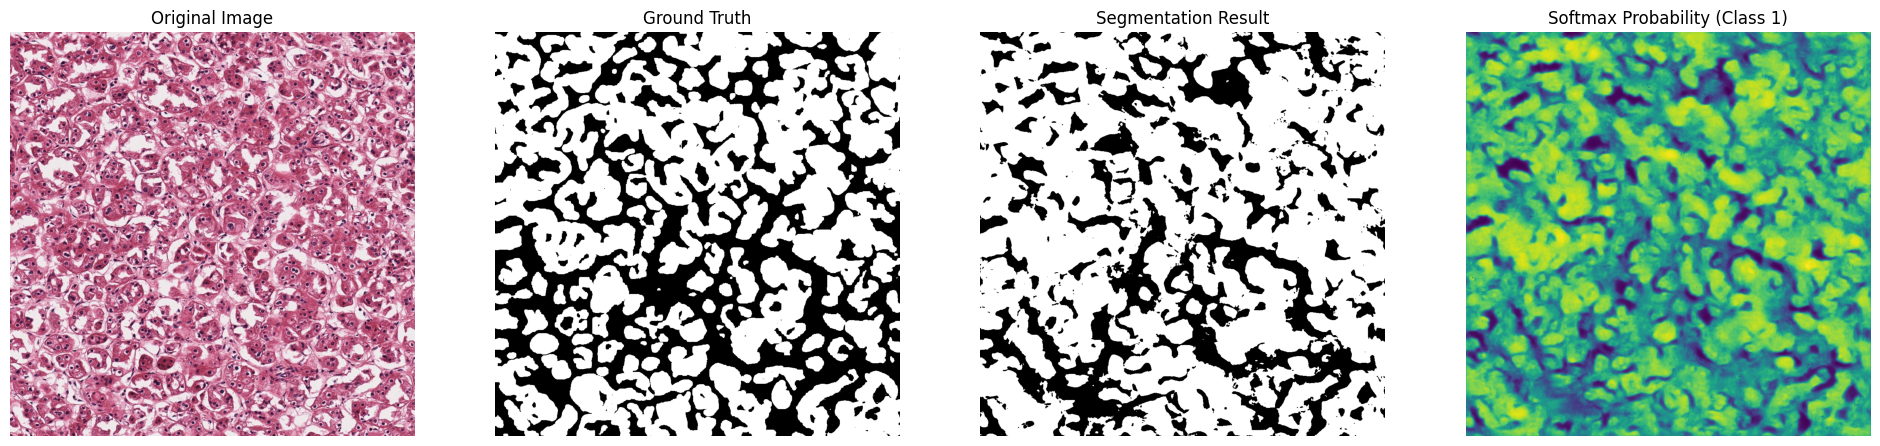

In [34]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import wandb

# Initialize a wandb run for inference (only for artifact usage)
run = wandb.init(
    project="ocelot_tissue_segmentation",
    job_type="inference",
    name="vanillaUnet_13"
)
# Use and download the best model artifact
artifact = run.use_artifact('drfahlan_/ocelot_tissue_segmentation/best_model:v12', type='model')
artifact_dir = artifact.download()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your model (adjust dropout as needed)
model = UNet(n_channels=3, n_classes=2, bilinear=True, dropout=config["dropout"]).to(device)
# Load the model weights from the downloaded artifact
model.load_state_dict(torch.load(os.path.join(artifact_dir, "best_model.pth"), map_location=device))
model.eval()

# Specify the test image subdirectory and the ground truth subdirectory
test_subdir = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/val/tissue"   # <-- update this path for test images
gt_subdir = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/annotations/val/tissue"          # <-- update this path for ground truth masks

def load_image(image_path):
    # Load an image with OpenCV (BGR) and convert to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def load_mask(mask_path):
    # Load ground truth mask as a grayscale image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Process the mask: convert 1 -> 0, 2 -> 1, and ignore 255 by setting them to 0 (for display)
    mask[mask == 1] = 0
    mask[mask == 2] = 1
    mask[mask == 255] = 0
    return mask

# Randomly select one image from the test subdirectory
image_files = [f for f in os.listdir(test_subdir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
if not image_files:
    raise ValueError("No image files found in the provided test subdirectory.")
random_file = random.choice(image_files)
test_image_path = os.path.join(test_subdir, random_file)

# Find the corresponding ground truth mask using the base filename (different file format possible)
import glob
base_name = os.path.splitext(random_file)[0]
gt_files = glob.glob(os.path.join(gt_subdir, base_name + ".*"))
if not gt_files:
    raise ValueError(f"Ground truth mask not found for {random_file} (base name: {base_name}) in {gt_subdir}.")
gt_path = gt_files[0]

# Load the original test image and ground truth mask
orig_image = load_image(test_image_path)
gt_mask = load_mask(gt_path)

# Preprocess the test image:
# 1. Convert to float and scale to [0, 1]
image_float = orig_image.astype(np.float32) / 255.0
# 2. Normalize to [-1, 1] using the same parameters as training: (x - 0.5)/0.5
image_norm = (image_float - 0.5) / 0.5
# 3. Convert to a torch tensor with shape (C, H, W) and add a batch dimension
image_tensor = torch.from_numpy(image_norm).permute(2, 0, 1).unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    outputs = model(image_tensor)
    # Apply softmax to get per-pixel probabilities
    softmax_outputs = F.softmax(outputs, dim=1)
    # Get segmentation result (predicted class per pixel)
    preds = torch.argmax(softmax_outputs, dim=1).squeeze(0).cpu().numpy()
    # Extract softmax probability for class 1 (assuming binary segmentation; index 1)
    softmax_class1 = softmax_outputs.squeeze(0)[1].cpu().numpy()

# Display the results
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(orig_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gt_mask, cmap="gray")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

axes[2].imshow(preds, cmap="gray")
axes[2].set_title("Segmentation Result")
axes[2].axis("off")

axes[3].imshow(softmax_class1, cmap="viridis")
axes[3].set_title("Softmax Probability (Class 1)")
axes[3].axis("off")

plt.show()

# Finish the wandb run
run.finish()


In [35]:
wandb.finish

<function wandb.sdk.wandb_run.finish(exit_code: 'int | None' = None, quiet: 'bool | None' = None) -> 'None'>

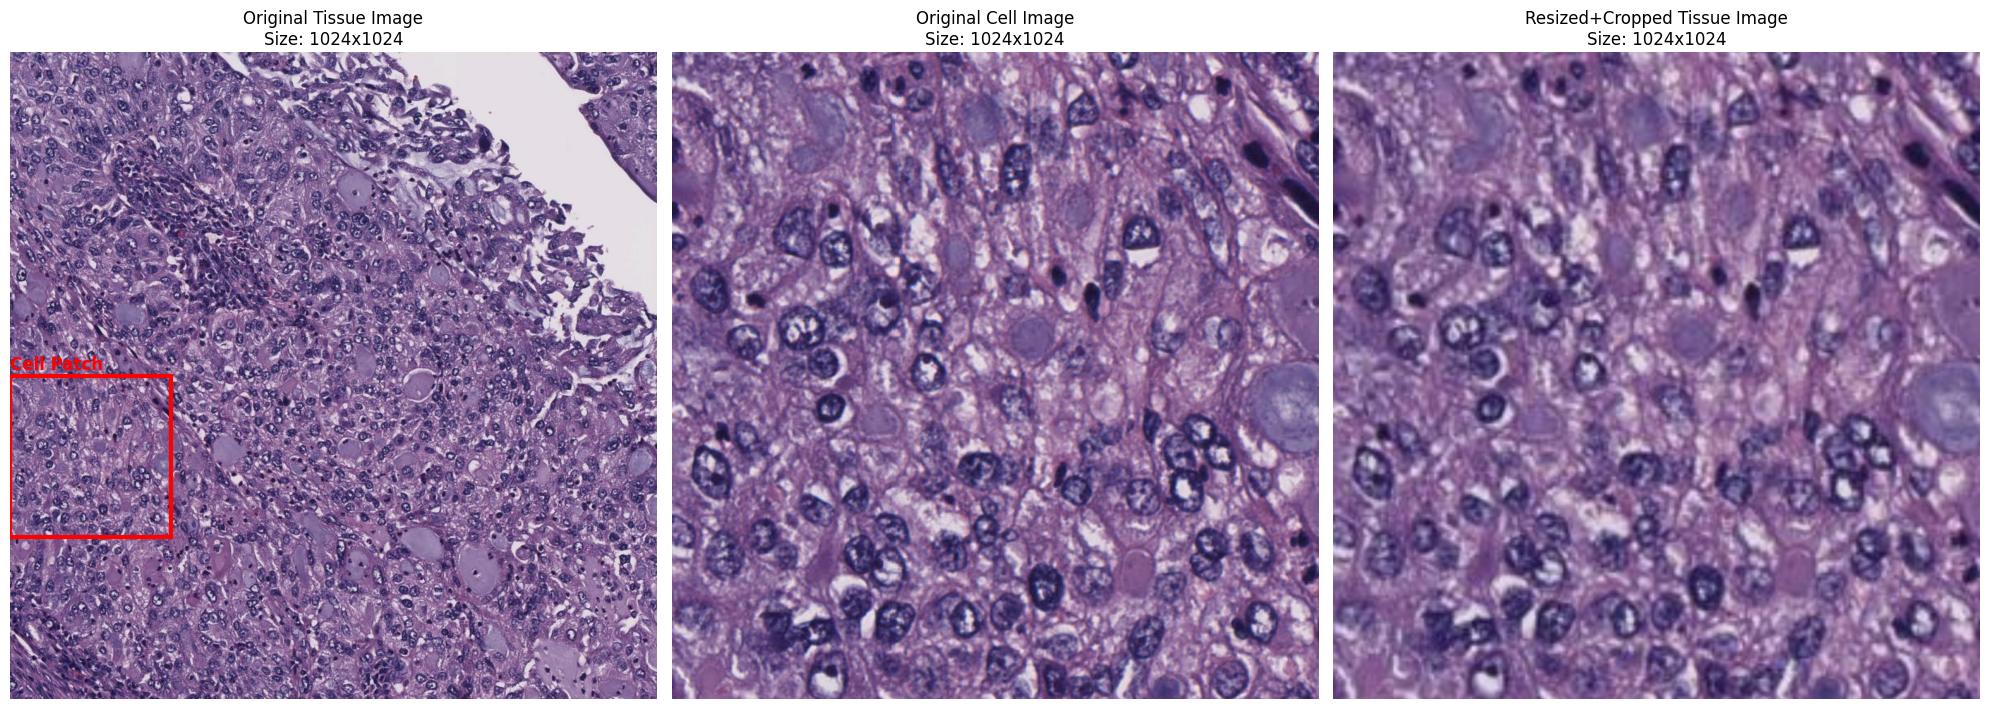

In [47]:
import os
import random
import json
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -------------------------------
# Parameters (adjust these paths)
# -------------------------------
metadata_path = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/metadata.json"
tissue_dir = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/train/tissue"
cell_dir   = "/content/drive/MyDrive/research/ocelot/dataset/ocelot2023_v1.0.1/images/train/cell"
target_size = 4096  # target dimension (width and height) for resizing images

# -------------------------------
# Helper function to get an image file path (supports .png and .jpg)
# -------------------------------
def get_image_path(directory, sample_id):
    for ext in ['.png', '.jpg']:
        path = os.path.join(directory, sample_id + ext)
        if os.path.exists(path):
            return path
    return None

# -------------------------------
# 1. Load metadata
# -------------------------------
with open(metadata_path, "r") as f:
    metadata = json.load(f)

# -------------------------------
# 2. List all tissue image files (png or jpg) and randomly select one
# -------------------------------
tissue_files = [f for f in os.listdir(tissue_dir) if f.lower().endswith(('.png', '.jpg'))]
if not tissue_files:
    raise FileNotFoundError("No tissue images found in the tissue directory.")

selected_file = random.choice(tissue_files)
sample_id = os.path.splitext(selected_file)[0]  # Remove extension to get sample ID

# -------------------------------
# 3. Verify metadata exists for the selected sample
# -------------------------------
if sample_id not in metadata["sample_pairs"]:
    raise KeyError(f"Sample {sample_id} not found in metadata.")

sample_data = metadata["sample_pairs"][sample_id]
tissue_info = sample_data["tissue"]
cell_info   = sample_data["cell"]
patch_x_offset = sample_data["patch_x_offset"]  # relative center x of cell patch within tissue patch
patch_y_offset = sample_data["patch_y_offset"]  # relative center y

# -------------------------------
# 4. Compute crop parameters for the resized tissue image (4096x4096)
# -------------------------------
# Original dimensions in the metadata (WSI coordinates) for tissue and cell patches
tissue_meta_width  = tissue_info["x_end"] - tissue_info["x_start"]
tissue_meta_height = tissue_info["y_end"] - tissue_info["y_start"]

cell_meta_width = cell_info["x_end"] - cell_info["x_start"]
cell_meta_height = cell_info["y_end"] - cell_info["y_start"]

# Ratio of cell patch size relative to tissue patch size
ratio_x = cell_meta_width / tissue_meta_width
ratio_y = cell_meta_height / tissue_meta_height

# Expected crop dimensions on the resized tissue image; use math.ceil to avoid off-by-one issues
crop_width  = math.ceil(target_size * ratio_x)
crop_height = math.ceil(target_size * ratio_y)

# Determine crop center in the resized tissue image using round (not int)
center_x = round(target_size * patch_x_offset)
center_y = round(target_size * patch_y_offset)

# Calculate crop boundaries (centered at (center_x, center_y)) and clamp to [0, target_size]
left = center_x - crop_width // 2
top  = center_y - crop_height // 2
if left < 0:
    left = 0
if top < 0:
    top = 0
right = left + crop_width
bottom = top + crop_height
if right > target_size:
    right = target_size
    left = right - crop_width
if bottom > target_size:
    bottom = target_size
    top = bottom - crop_height

# -------------------------------
# 5. Load the original images
# -------------------------------
# Tissue image (randomly selected)
tissue_img_path = os.path.join(tissue_dir, selected_file)
tissue_img_orig = cv2.imread(tissue_img_path)
if tissue_img_orig is None:
    raise FileNotFoundError(f"Could not load tissue image: {tissue_img_path}")
tissue_img_orig = cv2.cvtColor(tissue_img_orig, cv2.COLOR_BGR2RGB)

# Cell image (lookup by sample_id)
cell_img_path = get_image_path(cell_dir, sample_id)
if cell_img_path is None:
    raise FileNotFoundError(f"Cell image not found for sample {sample_id} in {cell_dir}")
cell_img_orig = cv2.imread(cell_img_path)
if cell_img_orig is None:
    raise FileNotFoundError(f"Could not load cell image: {cell_img_path}")
cell_img_orig = cv2.cvtColor(cell_img_orig, cv2.COLOR_BGR2RGB)

# -------------------------------
# 6. Compute bounding box for the cell patch in the original tissue image
# -------------------------------
# The tissue image corresponds to the tissue patch extracted from the WSI.
# Metadata coordinates (tissue_info) are in WSI space.
# Compute the cell patch's relative coordinates inside the tissue patch.
cell_rel_x_start = cell_info["x_start"] - tissue_info["x_start"]
cell_rel_y_start = cell_info["y_start"] - tissue_info["y_start"]
cell_rel_x_end   = cell_info["x_end"] - tissue_info["x_start"]
cell_rel_y_end   = cell_info["y_end"] - tissue_info["y_start"]

# Get original tissue image dimensions
orig_tissue_height, orig_tissue_width = tissue_img_orig.shape[:2]

# Compute scale factors (assuming the tissue image size matches the tissue patch dimensions)
scale_x = orig_tissue_width / tissue_meta_width
scale_y = orig_tissue_height / tissue_meta_height

# Calculate bounding box (top-left x,y and width, height) in the original tissue image
bbox_x = int(cell_rel_x_start * scale_x)
bbox_y = int(cell_rel_y_start * scale_y)
bbox_width = int((cell_rel_x_end - cell_rel_x_start) * scale_x)
bbox_height = int((cell_rel_y_end - cell_rel_y_start) * scale_y)

# -------------------------------
# 7. Resize and crop the tissue image
# -------------------------------
tissue_img_resized = cv2.resize(tissue_img_orig, (target_size, target_size))
tissue_img_cropped = tissue_img_resized[top:bottom, left:right]

# -------------------------------
# 8. Display the images with annotations
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# --- Original Tissue Image with Bounding Box ---
axes[0].imshow(tissue_img_orig)
axes[0].set_title(f"Original Tissue Image\nSize: {orig_tissue_width}x{orig_tissue_height}", fontsize=12)
axes[0].axis("off")
# Add bounding box using a red rectangle
rect = patches.Rectangle((bbox_x, bbox_y), bbox_width, bbox_height,
                          linewidth=3, edgecolor='red', facecolor='none')
axes[0].add_patch(rect)
axes[0].text(bbox_x, bbox_y - 10, "Cell Patch", color='red', fontsize=12, weight='bold')

# --- Original Cell Image ---
cell_h, cell_w = cell_img_orig.shape[:2]
axes[1].imshow(cell_img_orig)
axes[1].set_title(f"Original Cell Image\nSize: {cell_w}x{cell_h}", fontsize=12)
axes[1].axis("off")

# --- Resized & Cropped Tissue Image ---
cropped_h, cropped_w = tissue_img_cropped.shape[:2]
axes[2].imshow(tissue_img_cropped)
axes[2].set_title(f"Resized+Cropped Tissue Image\nSize: {cropped_w}x{cropped_h}", fontsize=12)
axes[2].axis("off")

plt.tight_layout()
plt.show()
